In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='Kai')
plt.rcParams['axes.unicode_minus'] =False
from pyqpanda import *
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

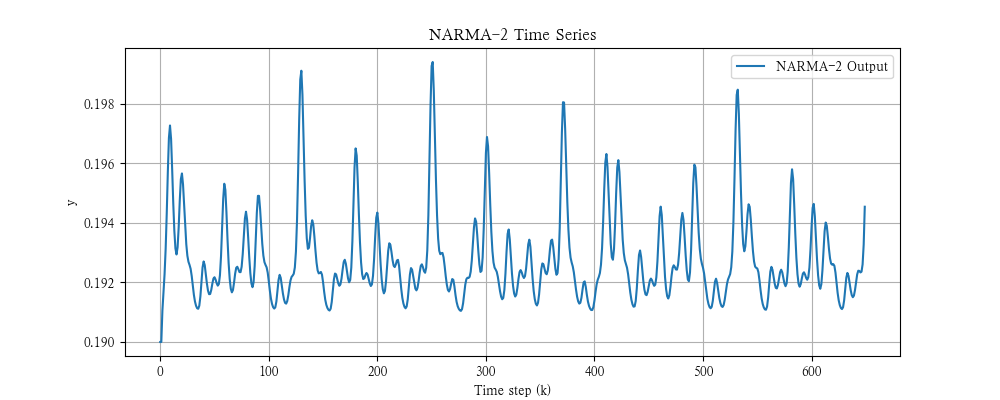

In [3]:
# 参数设置
T = 100
alpha = 2.11 / T
beta = 3.73 / T
gamma_val = 4.11 / T
num_steps = 650  # 总时间步数

# 初始化输入和输出序列
u = np.zeros(num_steps)
y = np.zeros(num_steps)
y[0] = 0.19
y[1] = 0.19  # 初始条件

# 生成输入信号 u_k
for k in range(num_steps):
    u[k] = 0.1 * (np.sin(2 * np.pi * alpha * k) *
                 np.sin(2 * np.pi * beta * k) *
                 np.sin(2 * np.pi * gamma_val * k) + 1)

# 计算 NARMA-2 输出（修正幂运算符 **）
for k in range(1, num_steps - 1):
    y[k + 1] = 0.4 * y[k] + 0.4 * y[k] * y[k - 1] + 0.6 * (u[k] ** 3) + 0.1  # 注意**运算符

# 划分训练集和测试集
train_data = y[:500]
test_data = y[500:650]

# 绘制结果
plt.figure(figsize=(10, 4))
plt.plot(y, label='NARMA-2 Output', color='tab:blue')
plt.xlabel('Time step (k)')
plt.ylabel('y')
plt.title('NARMA-2 Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### 4-qubit machine
# 在循环开始前初始化列表
all_sorted_values = []
# 对于4个量子比特，可能的状态总数是2^4=16
n_states = 16
# 初始化16个参数
params = [0.5*np.pi] * 16 
# 存储量子线路的输出结果
quantum_outputs = []
# 初始化上一次的概率值为None
prev_sorted_values = None
#参数\varepsilon
varepsilon = 0.2
#量子线路概率输入的层数
ccc = 4

for i in range(500):
    if i % 100 == 0:
        print(f"处理训练数据: {i}/500")
 
    if i > 0 and len(all_sorted_values) > 0:
       # 使用上一次的sorted_values更新参数
       prev_values = all_sorted_values[-1]
       for j in range(min(len(prev_values), 16)):
           params[j] = prev_values[j] *4*np.pi

    y_k = 4*np.pi*y[i]
    
    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    n_qubits = 4
    n_cbits = 4

    # 分配量子比特和经典比特
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)
    shots = 10000
    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    # 使用16个参数构建电路
    param_index = 0
    for layer in range(ccc):  # 4层，每层使用4个参数
        for qubit in range(4):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 3:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[3], qubits[0])
    # 添加Lorenz坐标相关的门
    circuit << RY(qubits[0], x_norm) 
    circuit << CNOT(qubits[0], qubits[1]) 
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[0])
    #circuit << 参数\beta
    prog << circuit << measure_all(qubits, cbits)
    # 运行多次量子程序，并返回测量结果
    result = qvm.run_with_configuration(prog, cbits, shots)
    # 计算概率分布
    total = shots
    probabilities = {}
    
    # 确保所有可能的状态都有值
    for state_idx in range(n_states):
        # 将索引转换为8位二进制字符串
        state = format(state_idx, '04b')
        # 如果状态在结果中，使用实际概率；否则为0
        probabilities[state] = round(result.get(state, 0) / total, 6)
    
    # 确保按照状态排序，而不是按照概率值排序
    sorted_states = sorted(probabilities.keys())
    raw_sorted_values = [probabilities[state] for state in sorted_states]
        
    # 非线性化处理
    if i > 0 and prev_values is not None:
        sorted_values = [0] * len(raw_sorted_values)
        for j in range(len(raw_sorted_values)):
            sorted_values[j] = round(varepsilon * raw_sorted_values[j] + (1 - varepsilon) * prev_values[j], 6)
    else:
        sorted_values = raw_sorted_values.copy()

    all_sorted_values.append(sorted_values)
    quantum_outputs.append(sorted_values)
    print("概率值：", raw_sorted_values[:16])

    qvm.finalize()


# 准备训练数据
X_train = []
y_train = []

# 使用量子输出和当前坐标预测下一个时间步的坐标
for i in range(499):
    # 特征：当前量子输出 + 当前坐标
    features = quantum_outputs[i] #+list(train_data[i])
    # 目标：下一个时间步的坐标
    target = train_data[i+1]
    X_train.append(features)
    y_train.append(target)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 训练岭回归模型
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
print("岭回归模型训练完成")
# 测试阶段：预测401-651时间步
predictions = []
current_state = train_data[-1]  # 从训练集最后一个状态开始
current_quantum_output = quantum_outputs[-1]  # 最后一个量子输出

# 初始化预测阶段的上一次概率值
prev_pred_values = current_quantum_output.copy()

for i in range(150):
    if i % 10 == 0:
        print(f"预测测试数据: {i}/150")
    
    # 特征：当前量子输出 + 当前坐标
    features = current_quantum_output #+ list(current_state)
    for j in range(min(len(features), 16)):
           params[j] = features[j] *4*np.pi
    # 预测下一个状态
    next_state = ridge.predict([features])[0]
    predictions.append(next_state)
    
    # 更新当前状态为预测的状态
    current_state = next_state

    # 使用预测的状态生成新的量子输出
    y_k = 4*np.pi*current_state
    
    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    n_qubits = 4
    n_cbits = 4
    # 分配量子比特和经典比特
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)
    shots = 10000

    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    param_index = 0
    for layer in range(ccc): 
        for qubit in range(4):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 3:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[3], qubits[0]) 
    circuit << RY(qubits[0], y_k) 
    circuit << CNOT(qubits[0], qubits[1])  
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[0])
    
    prog << circuit << measure_all(qubits, cbits)
    result = qvm.run_with_configuration(prog, cbits, shots)

    # 计算概率分布
    probabilities = {}
    for state_idx in range(n_states):
        state = format(state_idx, '08b')
        probabilities[state] = round(result.get(state, 0) / shots, 6)
    
    sorted_states = sorted(probabilities.keys())
    raw_quantum_output = [probabilities[state] for state in sorted_states]
    
    # 对预测阶段的概率也进行非线性化处理
    current_quantum_output = []
    for j in range(len(raw_quantum_output)):
        new_prob = round(varepsilon * raw_quantum_output[j] + (1 - varepsilon) * prev_pred_values[j], 6)
        current_quantum_output.append(new_prob)
    # 更新上一次的概率值
    prev_pred_values=current_quantum_output.copy()

    qvm.finalize()
predictions = np.array(predictions)

print(predictions)

# 计算预测误差
mse = mean_squared_error(test_data, predictions)
print(f"测试集MSE: {mse}")

# 保存预测结果和实际值
np.save('/Users/dyy/github/QRC_project1/quantum_predictions.npy', predictions)
np.save('/Users/dyy/github/QRC_project1/actual_values.npy', test_data)

# 修改后的绘图代码（仅展示一维对比）
plt.figure(figsize=(10, 5))

# 生成时间步坐标（测试集从501到650）
time_steps = range(501, 651)

# 绘制实际值和预测值对比
plt.plot(time_steps, test_data, 'b-', linewidth=1.5, label='实际值')
plt.plot(time_steps, predictions, 'r--', linewidth=1.5, label='预测值')

# 添加图注和标签
plt.title('NARMA-2时间序列预测对比')
plt.xlabel('时间步')
plt.ylabel('y值')
plt.legend()
plt.grid(True)

# 调整坐标轴范围
plt.xlim(500, 650)
plt.ylim(min(min(test_data), min(predictions))-0.1, 
         max(max(test_data), max(predictions))+0.1)

# 保存并显示图像
plt.tight_layout()
plt.savefig('/Users/dyy/github/QRC_project1/narma_prediction_comparison.png')
plt.show()

处理训练数据: 0/500


NameError: name 'traj_normalized' is not defined